SEC EDGAR XBRL API with Python
======

## Operating Cash Flow from Company Filings

----

*February 2026*<br>
*@bd_econ*

The SEC's [EDGAR](https://www.sec.gov/edgar) system provides free access to financial data from U.S. public company filings. The [XBRL company facts API](https://efts.sec.gov/LATEST/search-index?q=%22xbrl%22) returns standardized financial line items from 10-Q and 10-K filings as structured JSON. No API key is required, but a `User-Agent` header with contact information must be included.

This example retrieves quarterly **operating cash flow** for the "Magnificent 7" technology companies and displays the results as a stacked bar chart.

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time

### Parameters / Settings

The XBRL company facts API returns all reported facts for a company:

```
https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json
```

Companies are identified by their 10-digit CIK (Central Index Key) number, which can be looked up from ticker symbols. A `User-Agent` header with a name and email is required.

Cash flow items in quarterly (10-Q) filings are reported as **cumulative year-to-date** values. To get standalone quarterly figures, we compute the difference between consecutive cumulative periods within each fiscal year.

In [2]:
headers = {'User-Agent': 'econ_data brian.w.dew@gmail.com'}

# Look up CIK numbers from ticker symbols
tickers_url = 'https://www.sec.gov/files/company_tickers.json'
tickers = requests.get(tickers_url, headers=headers).json()
ticker_to_cik = {v['ticker']: str(v['cik_str']).zfill(10)
                 for v in tickers.values()}

companies = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA']
ciks = {t: ticker_to_cik[t] for t in companies}
for t, c in ciks.items():
    print(f'{t}: CIK {c}')

AAPL: CIK 0000320193
MSFT: CIK 0000789019
GOOGL: CIK 0001652044
AMZN: CIK 0001018724
NVDA: CIK 0001045810
META: CIK 0001326801
TSLA: CIK 0001318605


### Example 1: Apple Cash Flow Data

The `us-gaap` taxonomy in the company facts contains standardized financial line items. The XBRL tag for operating cash flow is `NetCashProvidedByUsedInOperatingActivities`.

In [3]:
# Fetch Apple's company facts
url = f'https://data.sec.gov/api/xbrl/companyfacts/CIK{ciks["AAPL"]}.json'
r = requests.get(url, headers=headers)
gaap = r.json()['facts']['us-gaap']

# Peek at the operating cash flow entries
ocf = pd.DataFrame(gaap['NetCashProvidedByUsedInOperatingActivities']['units']['USD'])
ocf = ocf[ocf['form'].isin(['10-Q', '10-K'])]
print(f'{len(ocf)} entries (includes duplicates from comparative periods)')
ocf[['start', 'end', 'val', 'form', 'fp', 'filed']].tail(8)

124 entries (includes duplicates from comparative periods)


,start,end,val,form,fp,filed
122,2023-10-01,2024-09-28,118254000000,10-K,FY,2024-11-01
123,2023-10-01,2024-09-28,118254000000,10-K,FY,2025-10-31
124,2024-09-29,2024-12-28,29935000000,10-Q,Q1,2025-01-31
125,2024-09-29,2024-12-28,29935000000,10-Q,Q1,2026-01-30
126,2024-09-29,2025-03-29,53887000000,10-Q,Q2,2025-05-02
127,2024-09-29,2025-06-28,81754000000,10-Q,Q3,2025-08-01
128,2024-09-29,2025-09-27,111482000000,10-K,FY,2025-10-31
129,2025-09-28,2025-12-27,53925000000,10-Q,Q1,2026-01-30


Each filing restates prior periods as comparatives, so the same data point appears multiple times with different `filed` dates. To deduplicate, we keep the latest filing for each unique `(start, end)` pair.

The cumulative pattern is:
- **Q1**: 3-month total (standalone)
- **Q2**: 6-month total (Q1 + Q2)
- **Q3**: 9-month total (Q1 + Q2 + Q3)
- **10-K**: 12-month total (full year)

Standalone Q2 = cumulative Q2 &minus; cumulative Q1, and so on.

In [4]:
def ytd_to_quarterly(entries):
    """Convert cumulative YTD entries to standalone quarterly values."""
    df = pd.DataFrame(entries)
    df = df[df['form'].str.startswith('10-')]
    df = (df.sort_values('filed')
            .drop_duplicates(subset=['start', 'end'], keep='last'))
    df['start'] = pd.to_datetime(df['start'])
    df['end'] = pd.to_datetime(df['end'])

    quarters = []
    for start_date, group in df.groupby('start'):
        group = group.sort_values('end')
        prev_end, prev_val = start_date, 0
        for _, row in group.iterrows():
            period_days = (row['end'] - prev_end).days
            if 60 <= period_days <= 120:
                midpoint = prev_end + (row['end'] - prev_end) / 2
                quarters.append({
                    'quarter': midpoint.to_period('Q'),
                    'val': row['val'] - prev_val
                })
            prev_end = row['end']
            prev_val = row['val']

    result = pd.DataFrame(quarters)
    return (result.sort_values('quarter')
                  .drop_duplicates(subset='quarter', keep='last')
                  .set_index('quarter')['val'])


def get_quarterly_ocf(cik, headers):
    """Fetch operating cash flow and return standalone quarterly values."""
    url = f'https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json'
    r = requests.get(url, headers=headers)
    gaap = r.json()['facts']['us-gaap']

    for tag in ['NetCashProvidedByUsedInOperatingActivities',
                'NetCashProvidedByOperatingActivities']:
        if tag in gaap:
            return ytd_to_quarterly(gaap[tag]['units']['USD'])


# Test with Apple
aapl_ocf = get_quarterly_ocf(ciks['AAPL'], headers)
print(f'{len(aapl_ocf)} quarters')
(aapl_ocf.tail(8) / 1e9).round(1)

61 quarters


quarter
2024Q1    22.7
2024Q2    28.9
2024Q3    26.8
2024Q4    29.9
2025Q1    24.0
2025Q2    27.9
2025Q3    29.7
2025Q4    53.9
Freq: Q-DEC, Name: val, dtype: float64

### Example 2: Magnificent 7 Operating Cash Flow

Fetch quarterly OCF for all seven companies. Not all of these companies use a standard calendar year:

| Company | Fiscal Year End | Fiscal Q1 → Calendar Q |
|---------|----------------|----------------------|
| AAPL | September | Oct–Dec → **Q4** |
| MSFT | June | Jul–Sep → **Q3** |
| NVDA | January | Feb–Apr → **Q1** |
| Others | December | Jan–Mar → **Q1** |

Each fiscal quarter is assigned to the **calendar quarter containing its midpoint**. NVIDIA's quarters are offset by about one month (e.g., its Feb–Apr fiscal Q1 is assigned to calendar Q1).

In [5]:
ocf_all = {}
for ticker, cik in ciks.items():
    ocf_all[ticker] = get_quarterly_ocf(cik, headers)
    time.sleep(0.15)  # respect rate limits
    print(f'{ticker}: {len(ocf_all[ticker])} quarters')

df = pd.DataFrame(ocf_all).dropna()
df = df[df.index >= '2022Q1']

# Find the longest contiguous block
full = pd.period_range(df.index[0], df.index[-1], freq='Q')
mask = full.isin(df.index)
best_start, best_len, cur_start, cur_len = 0, 0, 0, 0
for i, present in enumerate(mask):
    if present:
        if cur_len == 0:
            cur_start = i
        cur_len += 1
        if cur_len > best_len:
            best_start, best_len = cur_start, cur_len
    else:
        cur_len = 0

contiguous = df.loc[full[best_start]:full[best_start + best_len - 1]]
print(f'\n{best_len} contiguous quarters: {contiguous.index[0]} to {contiguous.index[-1]}')
(contiguous / 1e9).round(1)

AAPL: 61 quarters
MSFT: 57 quarters
GOOGL: 45 quarters
AMZN: 71 quarters
NVDA: 69 quarters
META: 58 quarters
TSLA: 49 quarters

16 contiguous quarters: 2022Q1 to 2025Q4


,AAPL,MSFT,GOOGL,AMZN,NVDA,META,TSLA
quarter,,,,,,,
2022Q1,28.2,25.4,25.1,-2.8,1.7,14.1,4.0
2022Q2,22.9,24.6,19.4,9.0,1.3,12.2,2.4
2022Q3,24.1,23.2,23.4,11.4,0.4,9.7,5.1
2022Q4,34.0,11.2,23.6,29.2,2.2,14.5,3.3
2023Q1,28.6,24.4,23.5,4.8,2.9,14.0,2.5
2023Q2,26.4,28.8,28.7,16.5,6.3,17.3,3.1
2023Q3,21.6,30.6,30.7,21.2,7.3,20.4,3.3
2023Q4,39.9,18.9,18.9,42.5,11.5,19.4,4.4
2024Q1,22.7,31.9,28.8,19.0,15.3,19.2,0.2


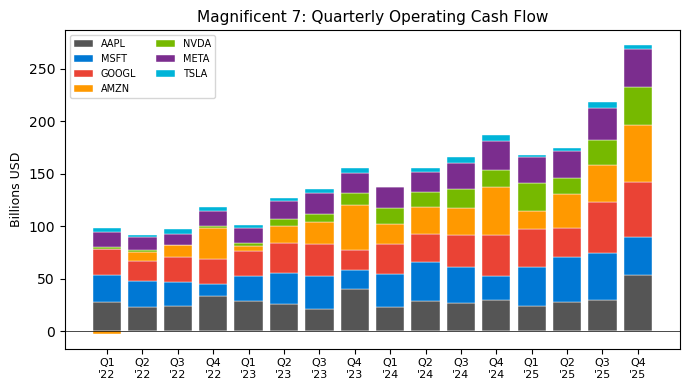

In [6]:
colors = {'AAPL': '#555555', 'MSFT': '#0078D4', 'GOOGL': '#EA4335',
          'AMZN': '#FF9900', 'NVDA': '#76B900', 'META': '#7B2D8E',
          'TSLA': '#00B4D8'}

fig, ax = plt.subplots(figsize=(7, 4))
x = range(len(contiguous))

# Stack positives up from zero, negatives down from zero
pos = contiguous.clip(lower=0) / 1e9
neg = contiguous.clip(upper=0) / 1e9
bottom_pos = pd.Series(0.0, index=contiguous.index)
bottom_neg = pd.Series(0.0, index=contiguous.index)

for company in companies:
    ax.bar(x, pos[company], bottom=bottom_pos, label=company,
           color=colors[company], width=0.8, edgecolor='white', linewidth=0.3)
    bottom_pos += pos[company]
    if neg[company].any():
        ax.bar(x, neg[company], bottom=bottom_neg,
               color=colors[company], width=0.8, edgecolor='white', linewidth=0.3)
        bottom_neg += neg[company]

labels = [f"Q{q.quarter}\n'{str(q.year)[2:]}" for q in contiguous.index]
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=8)
ax.set_ylabel('Billions USD', fontsize=9)
ax.set_title('Magnificent 7: Quarterly Operating Cash Flow', fontsize=11)
ax.legend(loc='upper left', fontsize=7, ncol=2)
ax.axhline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

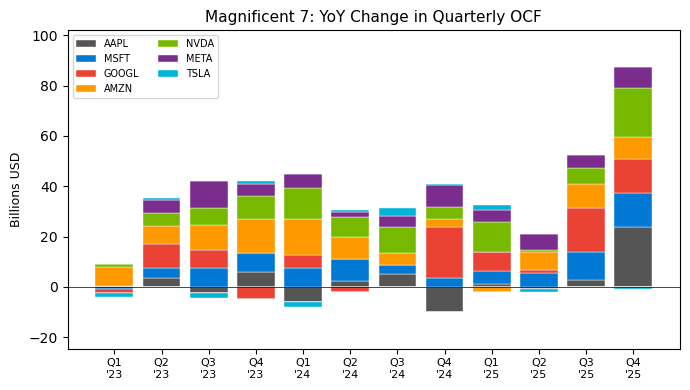

In [7]:
# Year-over-year change (same quarter, prior year)
yoy = (contiguous.diff(4) / 1e9).dropna()

fig, ax = plt.subplots(figsize=(7, 4))
x = range(len(yoy))

pos = yoy.clip(lower=0)
neg = yoy.clip(upper=0)
bottom_pos = pd.Series(0.0, index=yoy.index)
bottom_neg = pd.Series(0.0, index=yoy.index)

for company in companies:
    ax.bar(x, pos[company], bottom=bottom_pos, label=company,
           color=colors[company], width=0.8, edgecolor='white', linewidth=0.3)
    bottom_pos += pos[company]
    if neg[company].any():
        ax.bar(x, neg[company], bottom=bottom_neg,
               color=colors[company], width=0.8, edgecolor='white', linewidth=0.3)
        bottom_neg += neg[company]

labels = [f"Q{q.quarter}\n'{str(q.year)[2:]}" for q in yoy.index]
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=8)
ax.set_ylabel('Billions USD', fontsize=9)
ax.set_title('Magnificent 7: YoY Change in Quarterly OCF', fontsize=11)
ax.legend(loc='upper left', fontsize=7, ncol=2)
ax.axhline(0, color='black', linewidth=0.5)

# Add padding above and below stacked bars
ymin = neg.sum(axis=1).min()
ymax = pos.sum(axis=1).max()
margin = (ymax - ymin) * 0.15
ax.set_ylim(ymin - margin, ymax + margin)

plt.tight_layout()
plt.show()